<a href="https://colab.research.google.com/github/kritiyer/mydeeplabdemo/blob/master/CritikalNet_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import files
files.upload()

Saving model.py to model.py


{'model.py': b'# -*- coding: utf-8 -*-\n\n""" Deeplabv3+ model for Keras.\nThis model is based on TF repo:\nhttps://github.com/tensorflow/models/tree/master/research/deeplab\nOn Pascal VOC, original model gets to 84.56% mIOU\n\nMobileNetv2 backbone is based on this repo:\nhttps://github.com/JonathanCMitchell/mobilenet_v2_keras\n\n# Reference\n- [Encoder-Decoder with Atrous Separable Convolution\n    for Semantic Image Segmentation](https://arxiv.org/pdf/1802.02611.pdf)\n- [Xception: Deep Learning with Depthwise Separable Convolutions]\n    (https://arxiv.org/abs/1610.02357)\n- [Inverted Residuals and Linear Bottlenecks: Mobile Networks for\n    Classification, Detection and Segmentation](https://arxiv.org/abs/1801.04381)\n"""\n\nfrom __future__ import absolute_import\nfrom __future__ import division\nfrom __future__ import print_function\n\nimport numpy as np\nimport tensorflow as tf\nfrom keras import backend as K\n\nfrom tensorflow.keras.models import Model\nfrom tensorflow.keras imp

In [3]:
#@title Upload saved keras weights (downloaded from MBox)
def upload_files():
  from google.colab import files
  uploaded = files.upload()
  for k, v in uploaded.items():
    open(k, 'wb').write(v)
  return list(uploaded.keys())
upload_files()

Saving Demo_weights.h5 to Demo_weights.h5


['Demo_weights.h5']

In [4]:
#@title Imports

import os
from io import BytesIO
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import unsharp_mask
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from model import preprocess_input
from PIL import Image

print(tf.__version__)

Using TensorFlow backend.


1.15.0


In [0]:
#@title Helper methods

#create model instance

def create_model():
  from model import Deeplabv3
  from tensorflow.keras.layers import Input, Conv2D, Dense, Activation, BatchNormalization
  from tensorflow.keras.models import Sequential, Model
  inputs = Input(shape=(512, 512, 1))

  activation_func = None
  X1 = Conv2D(1, (5,5), strides=(1, 1), padding='same', dilation_rate=(1, 1), activation=activation_func, 
              use_bias=False, data_format="channels_last")(inputs)
  X2 = Conv2D(1, (3,3), strides=(1, 1), padding='same', dilation_rate=(1, 1), activation=activation_func, 
              use_bias=False, data_format="channels_last")(X1)
  X3 = Conv2D(16, (5,5), strides=(1, 1), padding='same', dilation_rate=(1, 1), activation=activation_func, 
              use_bias=False, data_format="channels_last")(X2)
  X4 = Conv2D(16, (5,5), strides=(1, 1), padding='same', dilation_rate=(1, 1), activation=activation_func, 
              use_bias=False, data_format="channels_last")(X3)
  X5 = Conv2D(16, (5,5), strides=(1, 1), padding='same', dilation_rate=(1, 1), activation=activation_func, 
              use_bias=False, data_format="channels_last")(X4)
  X6 = Conv2D(1, (3,3), strides=(1, 1), padding='same', dilation_rate=(1, 1), activation='tanh', 
              use_bias=False, data_format="channels_last")(X5)
  X7 = tf.keras.layers.concatenate([X6, X6, X6], axis=3)  

  unsharp_mask_model = Model(inputs=inputs, outputs=X7)
  deeplab_model = Deeplabv3(weights=None,backbone='xception',input_shape=(512,512,3), classes=2)

  combined_inputs = Input(shape=(512, 512, 1))
  unsharp_mask_img = unsharp_mask_model(combined_inputs)
  deeplab_img = deeplab_model(unsharp_mask_img)
  model = Model(combined_inputs,deeplab_img)

  return model

In [6]:
#@title load Deeplab model
model = create_model()
model.load_weights('Demo_weights.h5')
print('model loaded successfully!')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
model loaded successfully!


# **Run on sample images**
Upload any sample image file and copy the image filename to open it in the next code block

In [9]:
#@title upload sample image zip folder
files.upload()
!unzip -uq best_images.zip -d ./
!ls /content

Saving best_images.zip to best_images.zip
5goodimages	 Demo_weights.h5  __pycache__
best_images.zip  model.py	  sample_data


In [12]:
def label_preprocess(image):
  x = image==1
  x = x.astype('float32')
  return x

data_gen_args = dict(preprocessing_function = preprocess_input);
label_gen_args = dict(preprocessing_function = label_preprocess);

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**label_gen_args)

seed = 0

batchsize = 1;

image_generator = image_datagen.flow_from_directory(
    '/content/5goodimages/image',
    target_size=(512,512),
    color_mode='grayscale',
    class_mode=None,
    shuffle=False,
    batch_size=batchsize,
    seed=seed)

mask_generator = mask_datagen.flow_from_directory(
    '/content/5goodimages/label',
    target_size=(512,512),
    color_mode='grayscale',
    class_mode=None,
    shuffle=False,
    batch_size=batchsize,
    seed=seed)

Found 5 images belonging to 1 classes.
Found 5 images belonging to 1 classes.


nan
nan
0
0


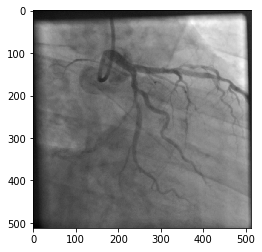

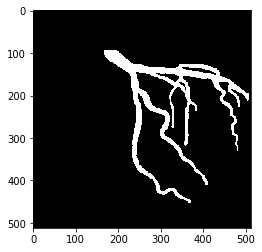

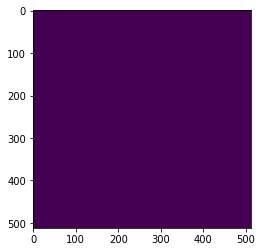

In [13]:
#@title Run on sample image (change IMAGE_URL to string output above) {display-mode: "form"}

inference = model.predict_generator(image_generator)
print(inference.min())
print(inference.max())

In [0]:
sess = tf.Session()
img = image_generator.next()
label = mask_generator.next()

plt.figure(); plt.imshow(np.squeeze(img), cmap="gray")
plt.figure(); plt.imshow(np.squeeze(label), cmap="gray")

full_sample = tf.nn.softmax(inference[0,:,:,:])
pred = tf.argmax(full_sample, axis=-1)
q = sess.run(pred)
print(q.min())
print(q.max())
q = q.astype('uint8')
plt.figure()
plt.imshow(q)